# Centrality Measure Definitions

In [2]:
from common_variables import *
DATA['paths']

Data loading complete!
Data loaded into DATA dictionary.


{'base_dir': '/Users/handan/Documents/CSBL/project-files/tme-network-topology',
 'dir_binary_rxns': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryRxnsTable.csv',
 'dir_binary_mets': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryMetsTable.csv',
 'dir_binary_genes': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryGenesTable.csv',
 'dir_umap_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output/umap_pos_data.csv',
 'dir_samples': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/samples',
 'dir_nodesedges': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/graphs',
 'dir_simulations': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/simulations',
 'dir_survival_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output_data'}

In [3]:
G_centrality_metrics = pd.read_csv('output/graph_topology_individiual_node_centralities.csv')
G_centrality_metrics = G_centrality_metrics.loc[:, (G_centrality_metrics != 0).any(axis=0)]

In [4]:
G_centrality_metrics

,Graph,Tissue,Type,Marker,Node,DegreeCentrality,InDegreeCentrality,OutDegreeCentrality,BetweennessCentrality,ClosenessCentrality,Pagerank,LoadCentrality,EigenvectorCentrality,MetaboliteID,MetaboliteName
0,Epithelial_Normal_Malignant,Normal,Epithelial,Malignant,1,0.001694,0.000726,0.000968,2.382074e-04,0.702062,0.000109,2.488061e-04,2.158257e-06,MAM00003c,(10Z)-heptadecenoic acid
1,Epithelial_Normal_Malignant,Normal,Epithelial,Malignant,2,0.000726,0.000484,0.000242,8.783458e-07,0.214380,0.000061,1.147705e-05,1.825730e-09,MAM00003l,(10Z)-heptadecenoic acid
2,Epithelial_Normal_Malignant,Normal,Epithelial,Malignant,3,0.001210,0.000484,0.000726,0.000000e+00,0.689182,0.000050,2.342256e-07,4.485259e-08,MAM00003r,(10Z)-heptadecenoic acid
3,Epithelial_Normal_Malignant,Normal,Epithelial,Malignant,4,0.003871,0.001936,0.001936,6.815671e-04,0.705445,0.000080,6.923122e-04,1.256200e-04,MAM00004c,(10Z)-heptadecenoyl-CoA
4,Epithelial_Normal_Malignant,Normal,Epithelial,Malignant,5,0.001694,0.001210,0.000484,4.700321e-04,0.715655,0.000087,4.582037e-04,3.394181e-09,MAM00004r,(10Z)-heptadecenoyl-CoA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84196,Macrophage_Tumor_VCAN+,Tumor,Macrophage,VCAN+,3898,0.000769,0.000513,0.000256,0.000000e+00,0.036934,0.000229,0.000000e+00,1.082323e-04,RSMSC029e,Bisulfite
84197,Macrophage_Tumor_VCAN+,Tumor,Macrophage,VCAN+,3899,0.000256,0.000256,0.000000,0.000000e+00,0.110998,0.000175,0.000000e+00,0.000000e+00,RSMSC022e,Sulfhydryl dimer radical anion
84198,Macrophage_Tumor_VCAN+,Tumor,Macrophage,VCAN+,3900,0.000513,0.000000,0.000513,0.000000e+00,0.000000,0.000051,0.000000e+00,0.000000e+00,RSMSC027e,sulfur dioxide anion radical
84199,Macrophage_Tumor_VCAN+,Tumor,Macrophage,VCAN+,3901,0.000513,0.000513,0.000000,0.000000e+00,0.207380,0.000166,0.000000e+00,0.000000e+00,RSMSC011e,Hydrogen thioperoxide


In [5]:
def parseReactionFormula(formula):
    parts = []
    direction = 'unknown'
    
    # Check for different arrow types
    if '<=>' in formula:  # Check for <=> (reversible)
        parts = formula.split('<=>')
        direction = 'reversible'
    elif '->' in formula:  # Check for -> (forward)
        parts = formula.split('->')
        direction = 'forward'
    
    if len(parts) != 2:
        return [], [], [], direction
    
    # Get inputs (left side of arrow)
    input_part = parts[0].strip()
    input_metabolites = [met.strip() for met in input_part.split('+')]
    
    # Get outputs (right side of arrow)
    output_part = parts[1].strip()
    output_metabolites = [met.strip() for met in output_part.split('+')]
    
    # Combine all metabolites (removing duplicates)
    all_metabolites = list(set(input_metabolites + output_metabolites))
    
    return input_metabolites, output_metabolites, all_metabolites, direction

def addMetabolitesToReactionsDF(binary_rxns_df): 
    # Create a copy to avoid modifying the original
    df_with_metabolites = binary_rxns_df.copy()
    
    # Add empty columns for metabolites
    df_with_metabolites['InMetabolites'] = None
    df_with_metabolites['OutMetabolites'] = None
    df_with_metabolites['AllMetabolites'] = None
    df_with_metabolites['Direction'] = None
    
    # Parse each reaction formula
    for idx, row in df_with_metabolites.iterrows():
        formula = row['rxnFormulas']
        in_mets, out_mets, all_mets, direction = parseReactionFormula(formula)
        
        # Add as lists for easier processing later
        df_with_metabolites.at[idx, 'InMetabolites'] = in_mets
        df_with_metabolites.at[idx, 'OutMetabolites'] = out_mets
        df_with_metabolites.at[idx, 'AllMetabolites'] = all_mets
        df_with_metabolites.at[idx, 'Direction'] = direction
         
    return df_with_metabolites

def countMetsInSubsystem(metabolites_classified, binary_rxns_df): 
    # Precompute metabolite occurrences in each subsystem for faster access
    metabolite_subsystem_map = defaultdict(lambda: defaultdict(int))

    # Iterate over each row in binary_rxns_df to build a mapping of metabolites to subsystems
    for _, rxn_row in binary_rxns_df.iterrows():
        metabolites_list = rxn_row['AllMetabolites']
        subsystem = rxn_row['subSystems']
        
        if isinstance(metabolites_list, list):  # Only process if metabolites_list is a list
            for metabolite in metabolites_list:
                metabolite_subsystem_map[metabolite][subsystem] += 1

    # Now, iterate over metabolites_classified and use the precomputed map
    result_df = metabolites_classified.copy()
    result_df['ReactionCount'] = 0
    result_df['SubsystemDetails'] = [{}] * len(result_df)
    
    # Process each metabolite in metabolites_classified
    for idx, row in result_df.iterrows():
        metabolite_id = str(row['MetaboliteID']).strip()
        
        # Get the subsystem counts from the precomputed map
        if metabolite_id in metabolite_subsystem_map:
            subsystem_counts = metabolite_subsystem_map[metabolite_id]
            result_df.at[idx, 'ReactionCount'] = sum(subsystem_counts.values())
            result_df.at[idx, 'SubsystemDetails'] = dict(subsystem_counts)
    
    return result_df

def classifyMetabolitesCentrality(centrality_df, binary_rxns_df=None, markers = 'FAP+', 
                         centrality_measures=['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'Pagerank', 'LoadCentrality', 'EigenvectorCentrality']):
    
    # Convert single marker to list for consistent processing
    if isinstance(markers, str):
        markers = [markers]
    
    all_results = []
    
    # Process each marker
    for marker in markers:
        # Filter data for this marker
        marker_data = centrality_df[centrality_df['Marker'] == marker].copy()
        
        if len(marker_data) == 0:
            continue
        
        # Get normal and tumor data
        normal_data = marker_data[marker_data['Tissue'] == 'Normal'].copy()
        tumor_data = marker_data[marker_data['Tissue'] == 'Tumor'].copy()
        
        if len(normal_data) == 0 or len(tumor_data) == 0:
            continue
        
        # Calculate ranks for each centrality measure
        for measure in centrality_measures:
            if measure in normal_data.columns:
                normal_data[f'{measure}_rank'] = normal_data[measure].rank(pct=True) * 100
            if measure in tumor_data.columns:
                tumor_data[f'{measure}_rank'] = tumor_data[measure].rank(pct=True) * 100
        
        # Find common metabolites
        normal_mets = set(normal_data['MetaboliteID'].dropna())
        tumor_mets = set(tumor_data['MetaboliteID'].dropna())
        common_mets = normal_mets.intersection(tumor_mets)
        
        marker_results = []
        
        # Process each metabolite
        for met_id in common_mets:
            normal_row = normal_data[normal_data['MetaboliteID'] == met_id].iloc[0]
            tumor_row = tumor_data[tumor_data['MetaboliteID'] == met_id].iloc[0]
            
            # Collect centrality values for classification
            normal_centrality_values = {}
            tumor_centrality_values = {}
            
            for measure in centrality_measures:
                if f'{measure}_rank' in normal_row and f'{measure}_rank' in tumor_row:
                    normal_centrality_values[measure] = normal_row[f'{measure}_rank']
                    tumor_centrality_values[measure] = tumor_row[f'{measure}_rank']
            
            # Skip if no measures were processed
            if not normal_centrality_values or not tumor_centrality_values:
                continue
            
            # Classify roles
            #normal_role = classify_by_max_centrality(normal_centrality_values)
            #tumor_role = classify_by_max_centrality(tumor_centrality_values)

            normal_role = max(normal_centrality_values, key=normal_centrality_values.get).replace('Centrality', '')
            tumor_role = max(tumor_centrality_values, key=tumor_centrality_values.get).replace('Centrality', '')

            # Update the role name
            role_dict = {'Degree': 'Degree', 
                         'Betweenness': 'Betweenness', 
                         'Closeness': 'Closeness', 
                         'Pagerank': 'Pagerank', 
                         'Load': 'Load', 
                         'Eigenvector': 'Eigenvector'}
            # role_dict = {'Degree': 'Connectivity', 
            #              'Betweenness': 'Bottleneck', 
            #              'Closeness': 'Reachability', 
            #              'Pagerank': 'Prominence', 
            #              'Load': 'Capacity', 
            #              'Eigenvector': 'Centrality'}
            normal_role = role_dict[normal_role]
            tumor_role = role_dict[tumor_role]
            
            # Store metabolite info
            marker_results.append({
                'MetaboliteID': met_id,
                'MetaboliteName': normal_row['MetaboliteName'],
                'Marker': marker,
                'NormalRole': normal_role,
                'TumorRole': tumor_role
            })
        
        # Add marker results to overall results
        all_results.extend(marker_results)
    
    # Convert to DataFrame
    classified_df = pd.DataFrame(all_results)

    # If binary_rxns_df exists
    if binary_rxns_df is not None:
        classified_df = countMetsInSubsystem(classified_df, binary_rxns_df)
    
    return classified_df


binary_rxns_df = addMetabolitesToReactionsDF(DATA['binary_rxns'])
metabolites_classified = classifyMetabolitesCentrality(G_centrality_metrics, binary_rxns_df, markers_all) 
#metabolites_classified.to_excel('output/metabolites_classified_by_their_highest_centrality_role.xlsx', index=False)


In [6]:
# Load Metabolic Network Function
def loadMetabolicNetworks(directory):
    G_list = []
    G_names = []
    
    # Find all node table files
    node_files = glob.glob(os.path.join(directory, 'NodeTable_*.csv'))
    if not node_files:
        print(f"No node table files found in directory: {directory}")
        return [], [], []
    print(f"Found node table files.\n")
    
    # Load each model
    for node_file in sorted(node_files):
        model_name = re.search(r'NodeTable_(.+)\.csv', node_file).group(1)
        edge_file = os.path.join(directory, f'EdgeTable_{model_name}.csv')

        # Check if edge file exists
        if not os.path.exists(edge_file):
            print(f"Warning: No edge table found for {model_name}")
            continue
        
        node_df = pd.read_csv(node_file)
        edge_df = pd.read_csv(edge_file)

        # Reverse edges where flux is negative
        edge_df['AdjustedSource'] = edge_df.apply(lambda row: row['Target'] if row['Flux'] < 0 else row['Source'], axis=1)
        edge_df['AdjustedTarget'] = edge_df.apply(lambda row: row['Source'] if row['Flux'] < 0 else row['Target'], axis=1)
        edge_df['AdjustedFlux'] = edge_df['Flux'].abs()  # Convert flux to positive after flipping

        # Create a MultiDiGraph to preserve all edges
        G = nx.MultiDiGraph()
        
        # Add nodes with metabolite names as attributes
        for _, row in node_df.iterrows():
            G.add_node(row['NodeID'], MetaboliteID=row['MetaboliteID'], MetaboliteName=row['MetaboliteName'])
        
        # Add edges to the graph, keeping all distinct reactions
        for _, row in edge_df.iterrows():
            G.add_edge(
                row['AdjustedSource'], row['AdjustedTarget'], key=row['ReactionID'],
                ReactionID=row['ReactionID'], 
                ReactionName=row.get('ReactionName', 'Undefined Rxn Name'),
                weight=row['AdjustedFlux']
            )

        G_list.append(G)
        G_names.append(model_name)
        print(f"Loaded model/graph {model_name} with {len(G.nodes)} nodes and {G.number_of_edges()} total edges.")

    return G_list, G_names

G_list, G_names = loadMetabolicNetworks(DATA['paths']['dir_nodesedges']) 
G_names = [name.replace('Cancer_', 'Epithelial_') for name in G_names]


Found node table files.

Loaded model/graph Cancer_Normal_Malignant with 4134 nodes and 40323 total edges.
Loaded model/graph Cancer_Tumor_Malignant with 4143 nodes and 41722 total edges.
Loaded model/graph Fibroblast_Normal_CD73+ with 3740 nodes and 35633 total edges.
Loaded model/graph Fibroblast_Normal_DES+ with 3407 nodes and 32961 total edges.
Loaded model/graph Fibroblast_Normal_FAP+ with 3843 nodes and 36331 total edges.
Loaded model/graph Fibroblast_Normal_FGFR2+ with 3842 nodes and 36185 total edges.
Loaded model/graph Fibroblast_Normal_ICAM1+ with 3729 nodes and 36882 total edges.
Loaded model/graph Fibroblast_Normal_ICAM1- with 3742 nodes and 38461 total edges.
Loaded model/graph Fibroblast_Normal_MFAP5+ with 3717 nodes and 33600 total edges.
Loaded model/graph Fibroblast_Tumor_CD73+ with 3761 nodes and 31701 total edges.
Loaded model/graph Fibroblast_Tumor_DES+ with 3535 nodes and 33331 total edges.
Loaded model/graph Fibroblast_Tumor_FAP+ with 3799 nodes and 39001 total ed

In [7]:
def getNodeInformationForFigure(G_centrality_metrics, graph_name, custom_metabolites, 
                                                     show_alternatives=True, top_n=5):
    # Filter metrics for this specific graph
    graph_metrics = G_centrality_metrics[G_centrality_metrics['Graph'] == graph_name].copy()
    
    # Centrality column mapping
    centrality_columns = {
        'degree': 'DegreeCentrality',
        'betweenness': 'BetweennessCentrality',
        'closeness': 'ClosenessCentrality',
        'eigenvector': 'EigenvectorCentrality',
        'pagerank': 'Pagerank',
        'load': 'LoadCentrality'
    }
    
    top_nodes = {}
    
    for cent_type, metabolite_name in custom_metabolites.items():
        if cent_type not in centrality_columns:
            print(f"  Warning: Unknown centrality type '{cent_type}'")
            continue
            
        col_name = centrality_columns[cent_type]
        
        # Find the specified metabolite
        metabolite_row = None
        
        if 'MetaboliteName' in graph_metrics.columns:
            matches = graph_metrics[graph_metrics['MetaboliteName'].str.lower() == metabolite_name.lower()]
            if not matches.empty:
                metabolite_row = matches.iloc[0]
        
        if metabolite_row is None:
            matches = graph_metrics[graph_metrics['Node'].astype(str) == str(metabolite_name)]
            if not matches.empty:
                metabolite_row = matches.iloc[0]
        
        if metabolite_row is None:
            print(f"  Warning: Metabolite '{metabolite_name}' not found for {cent_type}")
            
            # Show top alternatives even if specified metabolite not found
            if show_alternatives:
                print(f"    Top {top_n} metabolites for {cent_type}:")
                top_metabolites = graph_metrics.nlargest(top_n, col_name)
                for idx, row in top_metabolites.iterrows():
                    print(f"      - {row.get('MetaboliteName', row['Node'])}: {row[col_name]:.4f}")
            continue
        
        # Calculate rank of the selected metabolite
        metabolite_rank = (graph_metrics[col_name] > metabolite_row[col_name]).sum() + 1
        
        # Add to results
        result = {
            'node': metabolite_row['Node'],
            'metabolite_name': metabolite_row.get('MetaboliteName', metabolite_row['Node']),
            'metabolite_id': metabolite_row.get('MetaboliteID', metabolite_row['Node']),
            'score': metabolite_row[col_name],
            'rank': metabolite_rank,
            'total_nodes': len(graph_metrics)
        }
        
        # Add alternatives if requested
        if show_alternatives:
            top_metabolites = graph_metrics.nlargest(top_n, col_name)
            alternatives = []
            for idx, row in top_metabolites.iterrows():
                alternatives.append({
                    'metabolite_name': row.get('MetaboliteName', row['Node']),
                    'score': row[col_name]
                })
            result['alternatives'] = alternatives
        
        top_nodes[cent_type] = result
        
        print(f"  {cent_type}: {metabolite_row.get('MetaboliteName', 'N/A')} (rank {metabolite_rank}/{len(graph_metrics)}) - score: {metabolite_row[col_name]:.4f}")
        
        if show_alternatives and metabolite_rank > top_n:
            print(f"    Note: Selected metabolite is ranked #{metabolite_rank}. Top {min(3, top_n)} are:")
            for i, alt in enumerate(alternatives[:3], 1):
                print(f"      {i}. {alt['metabolite_name']}: {alt['score']:.4f}")
    
    return top_nodes

def extractSubgraphFromMetabolites(G, top_nodes_dict, depth=2, max_nodes_per_subgraph=20): 
    # Convert to undirected graph to discard directionality
    G_undirected = G.to_undirected()
    
    subnetworks = {}
    
    for cent_type, node_info in top_nodes_dict.items():
        center_node = node_info['node']
        
        # Check if node exists in graph
        if center_node not in G_undirected.nodes():
            print(f"  Warning: Node {center_node} not found in graph for {cent_type}")
            continue
        
        # Extract neighborhood using BFS
        if depth == 1:
            # Get immediate neighbors
            neighbors = set(G_undirected.neighbors(center_node))
            neighbors.add(center_node)
        else:
            # BFS to get all nodes within depth
            neighbors = {center_node}
            current_level = {center_node}
            
            for d in range(depth):
                next_level = set()
                for node in current_level:
                    next_level.update(G_undirected.neighbors(node))
                neighbors.update(next_level)
                current_level = next_level - neighbors
        
        # Create subgraph
        subgraph = G_undirected.subgraph(neighbors).copy()
        
        # Limit size if too large for visualization
        if len(subgraph.nodes()) > max_nodes_per_subgraph:
            # Keep the most connected nodes
            degrees = dict(subgraph.degree())
            sorted_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)
            keep_nodes = sorted_nodes[:max_nodes_per_subgraph]
            
            # Ensure center node is included
            if center_node not in keep_nodes:
                keep_nodes[-1] = center_node
            
            subgraph = subgraph.subgraph(keep_nodes).copy()
        
        # Extract labels from node attributes if available
        labels = {}
        for node in subgraph.nodes():
            # Try to get MetaboliteName from node attributes
            if 'MetaboliteName' in G.nodes[node]:
                labels[node] = G.nodes[node]['MetaboliteName']
            else:
                labels[node] = str(node)
        
        # Store subnetwork information
        subnetworks[cent_type] = {
            'subgraph': subgraph,
            'center_node': center_node,
            'center_metabolite': node_info['metabolite_name'],
            'centrality_score': node_info['score'],
            'labels': labels,
            'num_nodes': len(subgraph.nodes()),
            'num_edges': len(subgraph.edges())
        }
    
    return subnetworks

metabolitesForFigure = {
        'degree': 'ATP',
        'betweenness': 'PEP',
        'closeness': 'NAD+',
        'eigenvector': 'Na+',
        'pagerank': 'NADP+',
        'load': 'H2O'
    }
    
topMetabolitesToShow = getNodeInformationForFigure(
                            G_centrality_metrics, 
                            'Epithelial_Normal_Malignant',
                            metabolitesForFigure,
                            show_alternatives=True,
                            top_n=30
) 


subnetworksToShow = extractSubgraphFromMetabolites( G_list[G_names.index('Epithelial_Normal_Malignant')], 
                                                    topMetabolitesToShow, 
                                                    depth=2, 
                                                    max_nodes_per_subgraph=20
                                                )



  degree: ATP (rank 3/4134) - score: 0.4890
  betweenness: PEP (rank 384/4134) - score: 0.0011
    Note: Selected metabolite is ranked #384. Top 3 are:
      1. H+: 0.6109
      2. H2O: 0.4608
      3. H2O: 0.1472
  closeness: NAD+ (rank 158/4134) - score: 0.7242
    Note: Selected metabolite is ranked #158. Top 3 are:
      1. [apotransferin]: 2.5160
      2. antitrypsin: 1.4482
      3. haptoglobin: 1.4316
  eigenvector: Na+ (rank 1/4134) - score: 0.8307
  pagerank: NADP+ (rank 3/4134) - score: 0.0156
  load: H2O (rank 2/4134) - score: 0.3721


##### **(A)** Six centrality metrics identify distinct functional roles: degree centrality (highly connected hubs), betweenness centrality (metabolic bottlenecks), closeness centrality (central metabolites with rapid network access), PageRank centrality (prominence via key hub connections), load centrality (high-traffic carriers in pathways), and eigenvector centrality (structurally central in core metabolism). Abstract network representations illustrate each measure alongside biological examples from metabolic networks

Figure saved: fig3a_metabolite_centralities


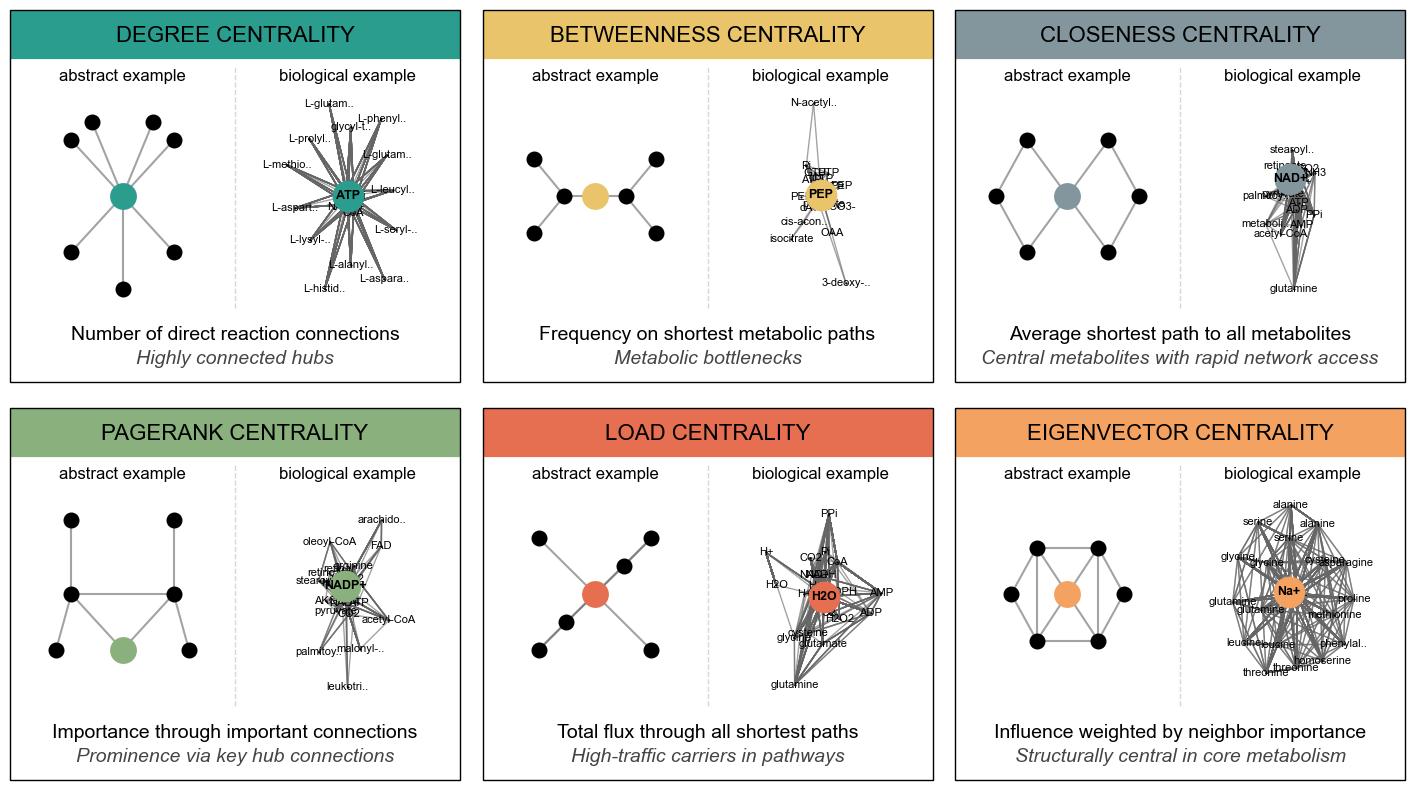

In [42]:
def drawCentralityNetworks(ax, centrality_type, color, title, symbol, description, bio_context, 
                               subgraph_data=None, show_ghosts=True):
    
    # Extend x-axis to accommodate both visualizations
    ax.set_xlim(-2.2, 2.2)  
    ax.set_ylim(-1, 1)
    ax.set_aspect('auto')
    ax.axis('off')
    
    # Add black border around the entire subplot
    rect = Rectangle((-2.2, -1), 4.4, 2, linewidth=1, edgecolor='black', facecolor='none', zorder=10, clip_on=False)
    ax.add_patch(rect)
    
    # Add vertical divider
    ax.plot([0, 0], [-.6, 0.7], color='#CCCCCC', linewidth=1, linestyle='--', alpha=0.8, zorder=1)
    
    # Title with colored bar underneath - spans both sides
    ax.text(0, 0.83, title.upper() +' CENTRALITY', color='black', ha='center', fontsize=16, zorder=2)
    ax.plot([-2.2, 2.2], [1, 1], color=color, linewidth=70, solid_capstyle='butt', zorder=1)
    
    # Subtitles for each side
    ax.text(-1.1, 0.62, 'abstract example',  color='black', ha='center', fontsize=12,  zorder=2)
    ax.text(1.1, 0.62, 'biological example', color='black', ha='center',  fontsize=12,  zorder=2)
    
    # LEFT SIDE: Abstract network visualization (shifted left)
    nodes = []
    edges = []
    ghost_nodes = []
    highlight_idx = None
    
    if centrality_type == 'degree':
        # Hub and spoke pattern
        nodes = [(-1.1, 0.1), (-1.6, -0.2), (-0.6, -0.2), (-1.6, 0.4), (-0.6, 0.4),
                (-1.1, -0.4), (-1.4, 0.5), (-0.8, 0.5)]
        highlight_idx = 0
        for i in range(1, len(nodes)):
            edges.append((0, i))
        ghost_nodes = [(-1.8, -0.3), (-0.4, -0.3), (-1.8, 0.5), (-0.4, 0.5)]
            
    elif centrality_type == 'betweenness':
        # Bridge pattern
        nodes = [(-1.7, -0.1), (-1.7, 0.3), (-1.4, 0.1), (-1.1, 0.1), 
                (-0.8, 0.1), (-0.5, -0.1), (-0.5, 0.3)]
        highlight_idx = 3
        edges = [(0, 2), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6)]
        ghost_nodes = [(-1.85, -0.25), (-1.85, 0.45), (-0.35, -0.25), (-0.35, 0.45)]
        
    elif centrality_type == 'closeness':
        # Central with short paths
        nodes = [(-1.1, 0.1), (-1.5, -0.2), (-0.7, -0.2), (-1.5, 0.4), 
                (-0.7, 0.4), (-1.8, 0.1), (-0.4, 0.1)]
        highlight_idx = 0
        edges = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 5), (2, 6), (3, 5), (4, 6)]
        ghost_nodes = [(-1.7, -0.35), (-0.5, -0.35), (-1.7, 0.55), (-0.5, 0.55)]
        
    elif centrality_type == 'pagerank':
        # Connected to important nodes
        nodes = [(-1.6, 0.1), (-0.6, 0.1), (-1.1, -0.2), (-1.75, -0.2), 
                (-0.45, -0.2), (-1.6, 0.5), (-0.6, 0.5)]
        highlight_idx = 2
        edges = [(0, 2), (1, 2), (3, 0), (4, 1), (5, 0), (6, 1), (0, 1)]
        ghost_nodes = [(-1.9, 0.1), (-0.3, 0.1), (-1.9, -0.35), (-0.3, -0.35)]
        
    elif centrality_type == 'load':
        # Multiple crossing paths
        nodes = [(-1.65, -0.2), (-1.65, 0.4), (-1.1, 0.1), (-0.55, -0.2), 
                (-0.55, 0.4), (-1.38, -0.05), (-0.82, 0.25)]
        highlight_idx = 2
        edges = [(0, 5), (5, 2), (2, 3), (1, 2), (2, 4), (0, 2), (2, 6), (6, 4)]
        ghost_nodes = [(-1.85, -0.35), (-1.85, 0.55), (-0.35, -0.35), (-0.35, 0.55)]
        
    elif centrality_type == 'eigenvector':
        # Well-connected cluster
        nodes = [(-1.1, 0.1), (-1.4, -0.15), (-0.8, -0.15), (-1.4, 0.35), 
                (-0.8, 0.35), (-1.65, 0.1), (-0.55, 0.1)]
        highlight_idx = 0
        edges = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (3, 4),
                (1, 5), (2, 6), (5, 3), (6, 4), (1, 3), (2, 4)]
        ghost_nodes = [(-1.55, -0.35), (-0.65, -0.35), (-1.55, 0.55), (-0.65, 0.55)]
    
    # Draw ghost nodes and their edges (if enabled)
    if show_ghosts:
        for ghost_x, ghost_y in ghost_nodes:
            distances = [(np.sqrt((ghost_x - nodes[i][0])**2 + (ghost_y - nodes[i][1])**2), i) 
                        for i in range(len(nodes))]
            distances.sort()
            for dist, node_idx in distances[:1]:
                if dist < 0.4:
                    x1, y1 = nodes[node_idx]
                    ax.plot([ghost_x, x1], [ghost_y, y1], 
                           color='#666666', alpha=0.2, linewidth=1, zorder=0)
        
        for ghost_x, ghost_y in ghost_nodes:
            ax.scatter(ghost_x, ghost_y, s=80, c='#888888', alpha=0.5, 
                      edgecolors='#888888', linewidth=1, zorder=2)
    
    # Draw edges
    for edge in edges:
        x1, y1 = nodes[edge[0]]
        x2, y2 = nodes[edge[1]]
        ax.plot([x1, x2], [y1- .1, y2- .1], color='#666666', alpha=0.6, linewidth=1.5, zorder=1)
    
    # Draw nodes
    for i, (x, y) in enumerate(nodes):
        if i == highlight_idx:
            ax.scatter(x, y - .1, s=300, c=color, edgecolors=color, linewidth=2, zorder=3)
        else:
            ax.scatter(x, y - .1, s=100, c='black', edgecolors='black', linewidth=1.5, zorder=3)
    
    # RIGHT SIDE: Actual subgraph (if provided)
    if subgraph_data:
        subgraph = subgraph_data['subgraph']
        center_node = subgraph_data['center_node']
        labels = subgraph_data.get('labels', {})
        
        # Calculate layout for subgraph
        try:
            pos = nx.spring_layout(subgraph, k=.7, iterations=50, seed=42)
        except:
            pos = nx.circular_layout(subgraph)
        
        # Scale and shift positions to right side
        for node in pos:
            pos[node] = (pos[node][0] * 0.6 + 1.1, pos[node][1] * 0.5)
        
        # Draw subgraph edges
        for edge in subgraph.edges():
            x1, y1 = pos[edge[0]]
            x2, y2 = pos[edge[1]]
            ax.plot([x1, x2], [y1, y2], color='#666666', alpha=0.6, linewidth=1, zorder=1)
        
        # Draw subgraph nodes
        for node in subgraph.nodes():
            x, y = pos[node]
            label = labels.get(node, str(node))
            if label == '[apotransferin]': label = 'apotransferin'
            elif len(str(label)) > 10:
                label = str(label)[:8] + '..'
            
            if node == center_node:
                # Highlight central node
                ax.scatter(x, y, s=500, c=color, edgecolors=color, linewidth=.5, zorder=5)
                ax.text(x, y, label, ha='center', va='center',  fontsize=9, weight='bold', color='black', zorder=7)
            else:
                # Regular nodes
                ax.scatter(x, y, s=1, c='black', edgecolors='black', linewidth=.5, zorder=3)
                ax.text(x, y, label, ha='center', va='center', fontsize=8, color='black', zorder=4)
    
    # Add descriptions (centered across both panels)
    ax.text(0, -0.7, description, ha='center', va='top', fontsize=14, weight='normal', color='black')
    
    # Biological context in italics
    ax.text(0, -0.83, bio_context, ha='center', va='top', fontsize=14, style='italic', color='#444444')

    return ax

def createCentralityFigure(subnetworks_dict, show_ghosts=True, figsize=(24, 10)):
    # Create the figure with 2x3 grid
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 3, wspace=0.05, hspace=.07)
    
    # Define the layout
    layout = [
        ('degree', gs[0, 0], 'DEGREE', 'Number of direct reaction connections', 'Highly connected hubs'),
        ('betweenness', gs[0, 1], 'BETWEENNESS', 'Frequency on shortest metabolic paths', 'Metabolic bottlenecks'),
        ('closeness', gs[0, 2], 'CLOSENESS', 'Average shortest path to all metabolites', 'Central metabolites with rapid network access'),
        ('pagerank', gs[1, 0], 'PAGERANK', 'Importance through important connections', 'Prominence via key hub connections'),
        ('load', gs[1, 1], 'LOAD', 'Total flux through all shortest paths', 'High-traffic carriers in pathways'),
        ('eigenvector', gs[1, 2], 'EIGENVECTOR', 'Influence weighted by neighbor importance', 'Structurally central in core metabolism')
    ]
    
    for cent_type, gridspec, title, description, bio_context in layout:
        ax = fig.add_subplot(gridspec)
        
        # Get subgraph data if available
        subgraph_data = subnetworks_dict.get(cent_type, None)
        
        # Define colors for each centrality
        colors = {
            'load': "#e76f51",
            'eigenvector': "#f4a261",
            'betweenness': "#e9c46a",
            'pagerank': "#8ab17d",
            'degree': "#2a9d8f",
            'closeness': "#83969D"
            
        } 
        # Draw the combined visualization
        drawCentralityNetworks(ax, cent_type, colors[cent_type], title, cent_type[0].upper(),
                                   description, bio_context, subgraph_data, show_ghosts)
    
    save_figure(fig, 'fig3a_metabolite_centralities')
    return

fig3a = createCentralityFigure(subnetworksToShow, show_ghosts=False, figsize=(18, 10))

##### **(B)** Context-specific metabolic network rewiring showing the same metabolite (highlighted node) exhibits distinct network topologies when analyzed in different biological contexts (in normal vs. tumor tissue).

Figure saved: fig3b_metabolite_centrality_transition


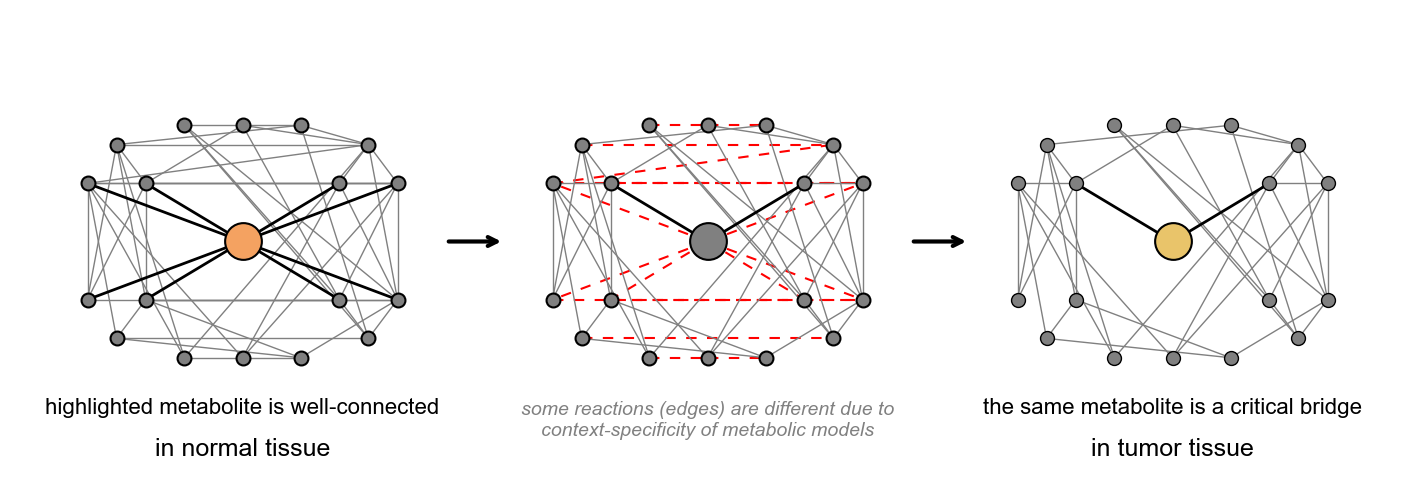

In [32]:
def create_eigenvector_to_bottleneck_graph():
    # Create the initial graph with high eigenvector centrality
    G_eigenvector = nx.Graph()
    
    # Define node positions for consistent layout
    center_node = 0
    
    # Left cluster - more nodes
    left_cluster = [1, 2, 3, 4, 5, 6]
    
    # Right cluster - more nodes
    right_cluster = [7, 8, 9, 10, 11, 12]
    
    # Additional nodes for complexity
    top_nodes = [13, 14, 15]
    bottom_nodes = [16, 17, 18]
    
    # Add all nodes
    all_nodes = [center_node] + left_cluster + right_cluster + top_nodes + bottom_nodes
    G_eigenvector.add_nodes_from(all_nodes)
    
    # INITIAL STATE: Center node is connected to many important nodes
    # Connect center to most nodes in clusters
    for node in left_cluster[:4] + right_cluster[:4]:
        G_eigenvector.add_edge(center_node, node)
    
    # Dense connections within left cluster
    for i in range(len(left_cluster)):
        for j in range(i+1, len(left_cluster)):
            if np.random.random() > 0.3:  # 70% connectivity
                G_eigenvector.add_edge(left_cluster[i], left_cluster[j])
    
    # Dense connections within right cluster
    for i in range(len(right_cluster)):
        for j in range(i+1, len(right_cluster)):
            if np.random.random() > 0.3:  # 70% connectivity
                G_eigenvector.add_edge(right_cluster[i], right_cluster[j])
    
    # Connect top nodes to clusters
    for node in top_nodes:
        targets = np.random.choice(left_cluster + right_cluster, size=3, replace=False)
        for target in targets:
            G_eigenvector.add_edge(node, target)
    
    # Connect bottom nodes to clusters
    for node in bottom_nodes:
        targets = np.random.choice(left_cluster + right_cluster, size=3, replace=False)
        for target in targets:
            G_eigenvector.add_edge(node, target)
    
    # CRITICAL: Cross-cluster edges that will be removed
    cross_edges = [
        (1, 7), (2, 8), (3, 9), (4, 10),  # Direct cross-cluster
        (5, 11), (6, 12),  # More cross-cluster
        (13, 14), (14, 15),  # Top connections
        (16, 17), (17, 18),  # Bottom connections
        (1, 9), (3, 11), (2, 10),  # Additional cross connections
    ]
    
    # Add cross edges that exist
    for edge in cross_edges:
        if edge[0] in G_eigenvector.nodes() and edge[1] in G_eigenvector.nodes():
            G_eigenvector.add_edge(edge[0], edge[1])
    
    # BOTTLENECK STATE: Remove cross-cluster connections
    G_bottleneck = G_eigenvector.copy()
    
    # Remove most connections from center except key ones
    edges_to_remove = []
    for edge in G_bottleneck.edges(center_node):
        if edge[1] not in [1, 7]:  # Keep only connection to node 1 and 7
            edges_to_remove.append((center_node, edge[1]))
    
    G_bottleneck.remove_edges_from(edges_to_remove)
    
    # Remove all cross-cluster edges
    for edge in cross_edges:
        if G_bottleneck.has_edge(edge[0], edge[1]):
            G_bottleneck.remove_edge(edge[0], edge[1])
    
    # Calculate removed edges
    removed_edges = list(set(G_eigenvector.edges()) - set(G_bottleneck.edges()))
    
    return G_eigenvector, G_bottleneck, center_node, removed_edges, all_nodes

def draw_three_panel_transformation(figsize=(24, 8)):
    # Create the graphs
    G_eigen, G_bottle, center_node, removed_edges, all_nodes = create_eigenvector_to_bottleneck_graph()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    eigenvector_color = "#f4a261"  # Orange for eigenvector
    bottleneck_color = "#e9c46a"   # Yellow for betweenness
    
    # Set up the canvas (expanded for three panels)
    ax.set_xlim(-3.6, 3.6)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # # Add main title with colored bar
    # title_text = "METABOLITE ROLE TRANSITION"
    # ax.text(0, 1.08, title_text, color='black', ha='center', fontsize=18,  zorder=2)
    # ax.plot([-3.6, 3.6], [1.2, 1.2], color="#9E9E9E", linewidth=70, solid_capstyle='butt', zorder=1)
    
    # # Add black border
    # rect = Rectangle((-3.6, -1.2), 7.2, 2.4, linewidth=1, edgecolor='black', facecolor='none', zorder=10, clip_on=False)
    # ax.add_patch(rect)

    # Add vertical dividers with arrows
    ax.annotate('', xy=(-1.05, 0), xytext=(-1.35, 0),  arrowprops=dict(arrowstyle='->', lw=3, color='black'))
    ax.annotate('', xy=(1.35, 0), xytext=(1.05, 0), arrowprops=dict(arrowstyle='->', lw=3, color='black'))
    
    # Define fixed positions for all graphs
    pos = {}
    
    # Center node
    pos[0] = np.array([0, 0])
    
    # Left cluster
    pos[1] = np.array([-0.5, 0.3])
    pos[2] = np.array([-0.5, -0.3])
    pos[3] = np.array([-0.8, 0.3])
    pos[4] = np.array([-0.8, -0.3])
    pos[5] = np.array([-0.65, 0.5])
    pos[6] = np.array([-0.65, -0.5])
    
    # Right cluster
    pos[7] = np.array([0.5, 0.3])
    pos[8] = np.array([0.5, -0.3])
    pos[9] = np.array([0.8, 0.3])
    pos[10] = np.array([0.8, -0.3])
    pos[11] = np.array([0.65, 0.5])
    pos[12] = np.array([0.65, -0.5])
    
    # Top nodes
    pos[13] = np.array([-0.3, 0.6])
    pos[14] = np.array([0, 0.6])
    pos[15] = np.array([0.3, 0.6])
    
    # Bottom nodes
    pos[16] = np.array([-0.3, -0.6])
    pos[17] = np.array([0, -0.6])
    pos[18] = np.array([0.3, -0.6])
    
    # LEFT SIDE: High Eigenvector Centrality (duplicate of CENTER)
    offset_left = np.array([-2.4, 0])
    
    # Draw all edges for left graph
    for edge in G_eigen.edges():
        x1, y1 = pos[edge[0]] + offset_left
        x2, y2 = pos[edge[1]] + offset_left
        # Emphasize paths through center node
        if center_node in edge:
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=2, zorder=2)
        else:
            ax.plot([x1, x2], [y1, y2], color='gray', linewidth=1, zorder=1)
    
    # Draw nodes for left graph
    for node in G_eigen.nodes():
        x, y = pos[node] + offset_left
        if node == center_node:
            # Highlight center node with eigenvector color
            size = 700 
            ax.scatter(x, y, s=size, c=eigenvector_color, edgecolors='black', linewidth=1.5, zorder=5)
        else:
            # Size based on eigenvector centrality
            size = 100
            ax.scatter(x, y, s=size, c='gray', edgecolors='black', linewidth=1.5, zorder=3)
    
    # CENTER: Transition
    offset_center = np.array([0, 0])
    
    # First draw removed edges as semi-transparent
    for edge in removed_edges:
        if edge[0] in pos and edge[1] in pos:
            x1, y1 = pos[edge[0]] + offset_center
            x2, y2 = pos[edge[1]] + offset_center
            ax.plot([x1, x2], [y1, y2], color='red', linestyle='--', dashes=(5, 5), linewidth=1.5, zorder=0)
    
    # Draw remaining edges for right graph
    for edge in G_bottle.edges():
        x1, y1 = pos[edge[0]] + offset_center
        x2, y2 = pos[edge[1]] + offset_center
        # Emphasize paths through center node
        if center_node in edge:
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=2, zorder=2)
        else:
            ax.plot([x1, x2], [y1, y2], color='gray', linewidth=1, zorder=1)
    
    # Draw nodes for right graph
    for node in G_bottle.nodes():
        x, y = pos[node] + offset_center
        if node == center_node:
            # Highlight as bottleneck with betweenness color
            size = 700 
            ax.scatter(x, y, s=size, c='gray',  edgecolors='black', linewidth=1.5, zorder=5)
        else:
            # Smaller nodes for non-bottleneck
            size = 100
            ax.scatter(x, y, s=size, c='gray', edgecolors='black', linewidth=1.5, zorder=3)
    
    # RIGHT SIDE: Bottleneck Configuration
    offset_right = np.array([2.4, 0])
    
    # First draw removed edges as semi-transparent
    for edge in removed_edges:
        if edge[0] in pos and edge[1] in pos:
            x1, y1 = pos[edge[0]] + offset_right
            x2, y2 = pos[edge[1]] + offset_right
            ax.plot([x1, x2], [y1, y2], color='white', linewidth=0, zorder=0)
    
    # Draw remaining edges for right graph
    for edge in G_bottle.edges():
        x1, y1 = pos[edge[0]] + offset_right
        x2, y2 = pos[edge[1]] + offset_right
        # Emphasize paths through center node
        if center_node in edge:
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=2, zorder=2)
        else:
            ax.plot([x1, x2], [y1, y2], color='gray', linewidth=1, zorder=1)
    
    # Draw nodes for right graph
    for node in G_bottle.nodes():
        x, y = pos[node] + offset_right
        if node == center_node:
            # Highlight as bottleneck with betweenness color
            size = 700 
            ax.scatter(x, y, s=size, c=bottleneck_color,  edgecolors='black', linewidth=1.5, zorder=5)
        else:
            # Smaller nodes for non-bottleneck
            size = 100
            ax.scatter(x, y, s=size, c='gray', edgecolors='black', linewidth=1, zorder=3)
    
    # Add descriptions

    ax.text(-2.4, -1.1, 'in normal tissue', fontsize=18, color='black',  ha='center', zorder=2)
    ax.text(-2.4, -0.8, 'highlighted metabolite is well-connected', ha='center', va='top', fontsize=16)

    ax.text(0, -0.82, 'some reactions (edges) are different due to\ncontext-specificity of metabolic models',  ha='center',  va='top', fontsize=14, color='gray', style='italic')

    ax.text(2.4, -1.1, 'in tumor tissue', fontsize=18, color='black', ha='center', zorder=2)
    ax.text(2.4, -0.8, 'the same metabolite is a critical bridge', ha='center', va='top', fontsize=16)
    
    save_figure(fig, 'fig3b_metabolite_centrality_transition')
    return fig

np.random.seed(42)
fig3b = draw_three_panel_transformation(figsize=(18, 8))
    

Figure saved: Figure3_Centrality_Definitions


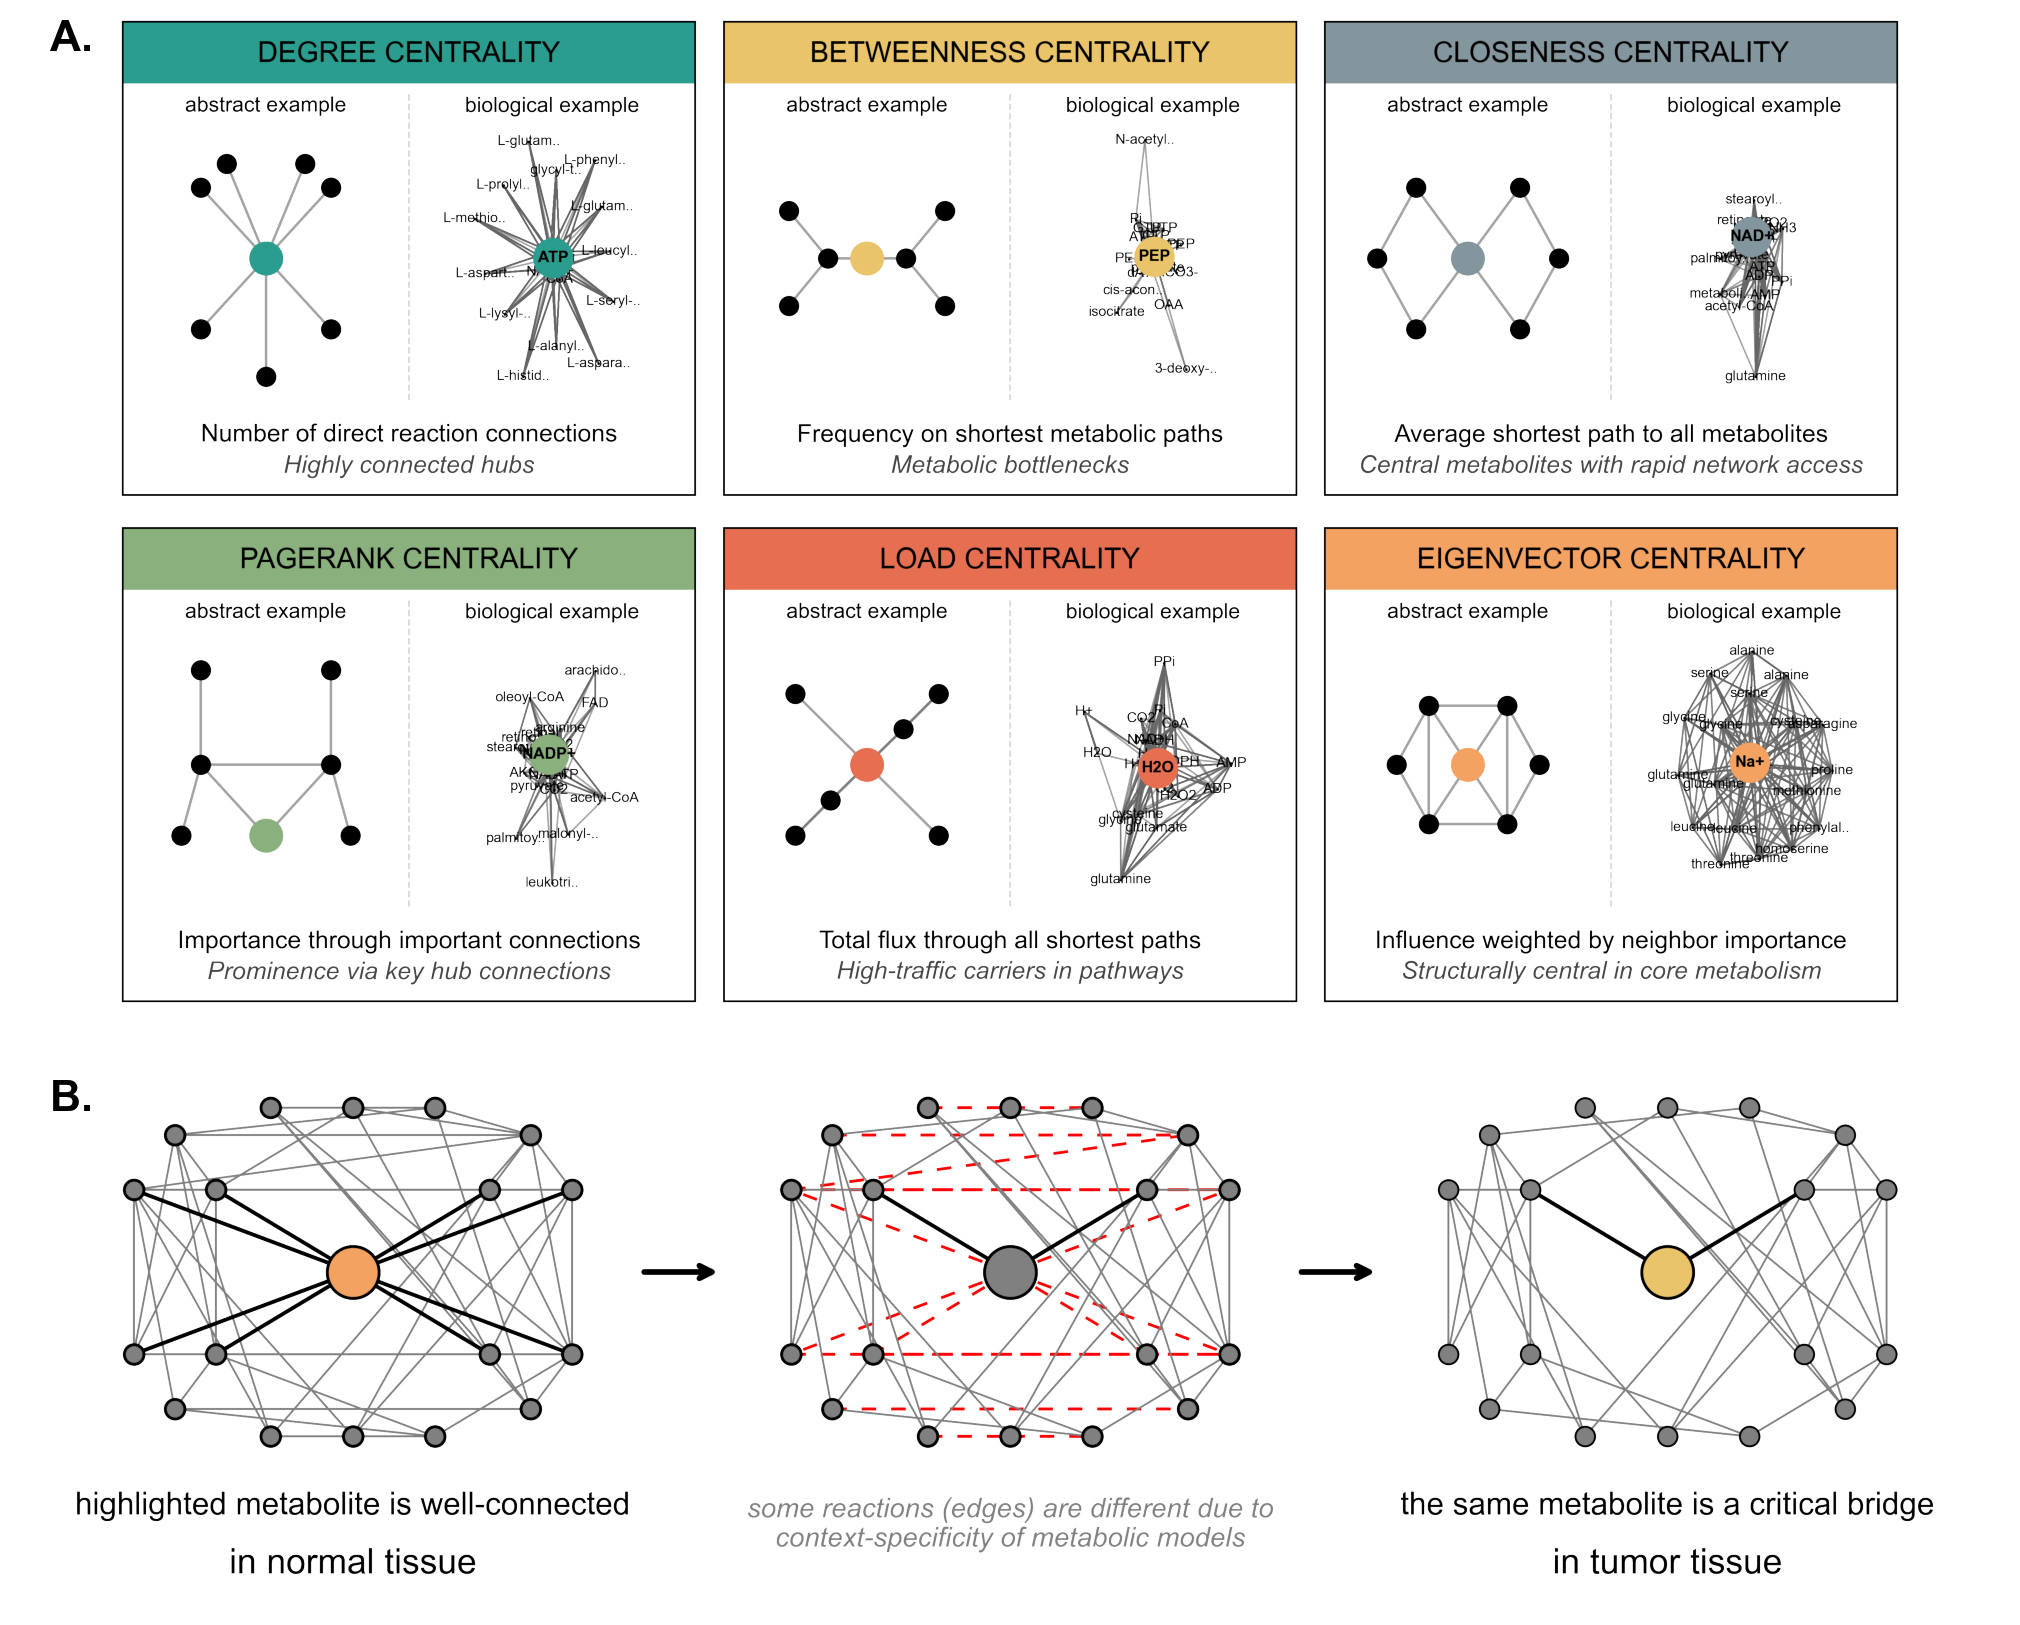

In [51]:
fig = plt.figure(figsize=(20, 20))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        if label == 'B': 
            bottom -= 0.07  # slight adjustment for B
            x += 0.05
        fig.text(x-0.03, bottom + h -0.005, label +'. ', fontsize=31, ha='left', va='top', fontweight='bold')

add_panel("../figures/png/fig3a_metabolite_centralities.png",           [0, 0, .9],     "A")
add_panel("../figures/png/fig3b_metabolite_centrality_transition.png",  [-0.05, 0.46, 1],   "B")

save_figure(fig, 'Figure3_Centrality_Definitions')